In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

In [9]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [10]:
DATASET_ID = 'macaque_coo'

In [11]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [12]:
from avgn.signalprocessing.create_spectrogram_dataset import prepare_wav, create_label_df, get_row_audio

### create dataset

In [180]:
hparams = HParams(
    num_mel_bins = 32,
    mel_lower_edge_hertz=50,
    mel_upper_edge_hertz=1500,
    butter_lowcut = 50,
    butter_highcut = 1500,
    ref_level_db = 20,
    min_level_db = -50,
    mask_spec = True,
    win_length_ms = 10,
    hop_length_ms = 2,
    mask_spec_kwargs = {"spec_thresh": 0.9, "offset": 1e-10}
)

In [181]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

In [182]:
dataset.sample_json

OrderedDict([('samplerate_hz', 24414),
             ('length_s', 0.5768411567133612),
             ('wav_loc', '/mnt/cube/Datasets/Macaque/dataupload/QU/QU961.wav'),
             ('idnum', 961),
             ('indvs',
              OrderedDict([('QU',
                            OrderedDict([('coos',
                                          OrderedDict([('start_times', [0.0]),
                                                       ('end_times',
                                                        [0.5768411567133612])]))]))]))])

#### Create dataset based upon JSON

In [76]:
from joblib import Parallel, delayed
n_jobs = -1; verbosity = 10

In [77]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(create_label_df)(
            dataset.data_files[key].data,
            hparams=dataset.hparams,
            labels_to_retain=[],
            unit="coos",
            key = key,
        )
        for key in tqdm(dataset.data_files.keys())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1935s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1473s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 101 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1659s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 253 tasks      | elapsed: 

7285

In [78]:
syllable_df[:3]

start_time  end_time indv  indvi    key
0         0.0  0.576841   QU      0  QU961
0         0.0  0.070544   SN      0  SN961
0         0.0  0.474031   QU      0  QU479

### get audio for dataset

In [129]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(get_row_audio)(
            syllable_df[syllable_df.key == key], 
            dataset.data_files[key].data['wav_loc'], 
            dataset.hparams
        )
        for key in tqdm(syllable_df.key.unique())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1096s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 298 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 386 ta

7285

In [130]:
syllable_df[:3]

start_time  end_time indv  indvi    key  \
0         0.0  0.576841   QU      0  QU961   
0         0.0  0.070544   SN      0  SN961   
0         0.0  0.474031   QU      0  QU479   

                                               audio   rate  \
0  [-1.5382879036171296e-05, -0.00013294855745331...  24414   
0  [-6.30847800886783e-07, -6.1899308990145226e-0...  44100   
0  [3.997810370982371e-06, 3.1708158648103554e-05...  24414   

                                         spectrogram  
0  [[0.0, 0.0, 0.20121188, 0.264632, 0.1762594, 0...  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.054505512, 0...  
0  [[0.0, 0.0, 0.0, 0.0593327, 0.07071316, 0.0199...

In [131]:
syllable_df.indvi.values[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [132]:
sylls = syllable_df.audio.values

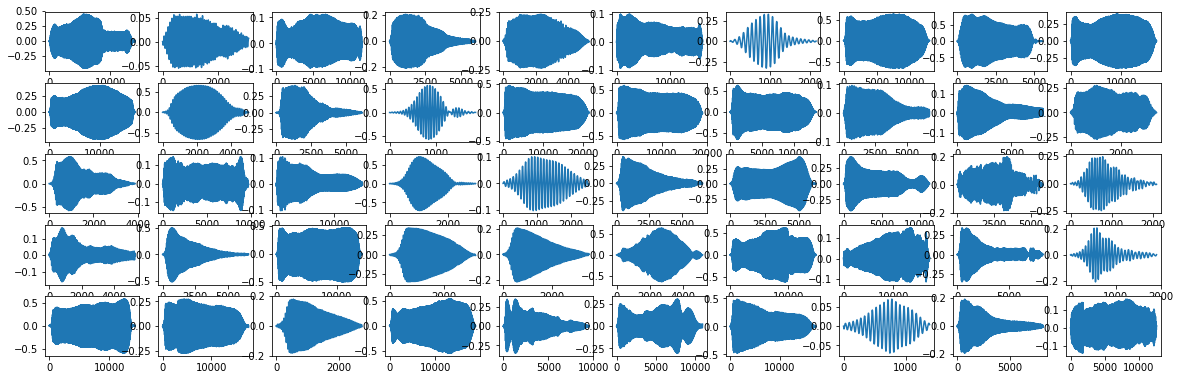

In [133]:
nrows = 5
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(sylls), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows*ncols -1:
        break

### Create spectrograms

In [183]:
from avgn.visualization.spectrogram import draw_spec_set
from avgn.signalprocessing.create_spectrogram_dataset import make_spec, mask_spec, log_resize_spec, pad_spectrogram

In [184]:
syllables_wav = syllable_df.audio.values
syllables_rate = syllable_df.rate.values

In [185]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    # create spectrograms
    syllables_spec = parallel(
        delayed(make_spec)(
            syllable,
            rate,
            hparams=dataset.hparams,
            mel_matrix=dataset.mel_matrix,
            use_mel=True,
            use_tensorflow=False,
        )
        for syllable, rate in tqdm(
            zip(syllables_wav, syllables_rate),
            total=len(syllables_rate),
            desc="getting syllable spectrograms",
            leave=False,
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0222s.) Setting batch_size=18.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1423s.) Setting batch_size=50.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 260 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 710 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1160 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1710 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2260 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 2910 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 3560 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 4310 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 5060 tasks      | elapsed:    3.4s
[Par

### Rescale spectrogram
- using log rescaling

In [186]:
log_scaling_factor = 4

In [187]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(log_resize_spec)(spec, scaling_factor=log_scaling_factor)
        for spec in tqdm(syllables_spec, desc="scaling spectrograms", leave=False)
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0056s.) Setting batch_size=72.
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1286s.) Setting batch_size=222.
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 840 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2238 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 7285 out of 7285 | elapsed:    1.2s finished


(25.0, 10) (320, 800) 25.0 32 800


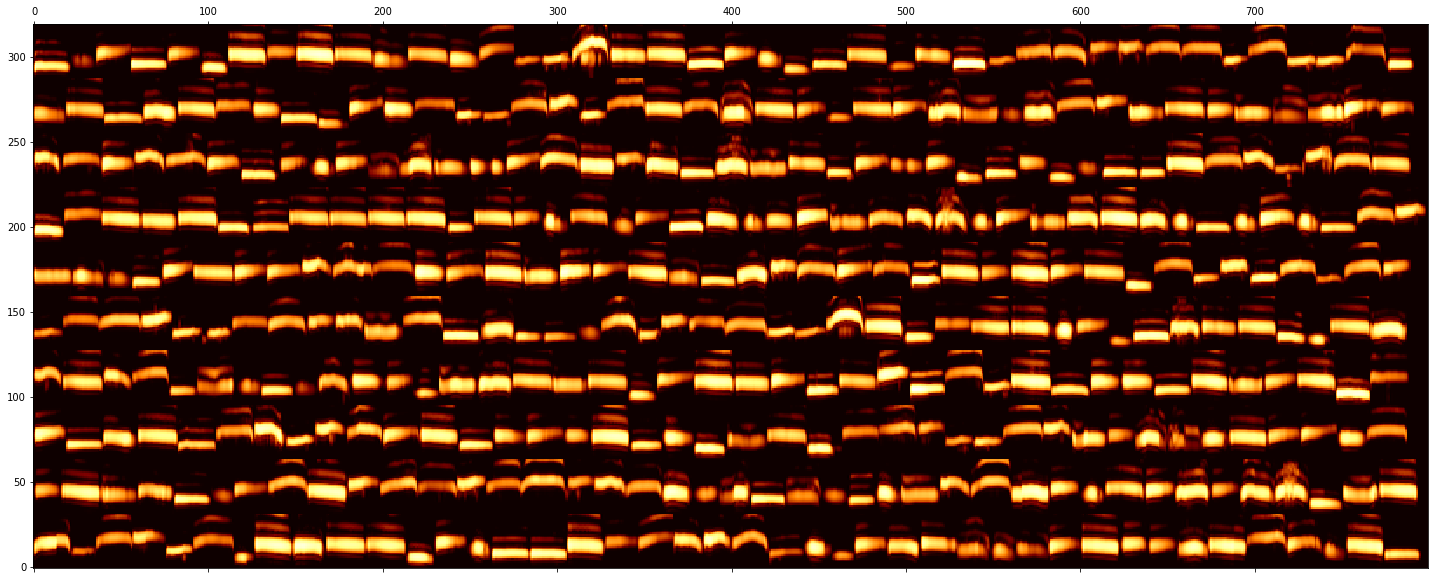

In [188]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

### Pad spectrograms

In [189]:
syll_lens = [np.shape(i)[1] for i in syllables_spec]
pad_length = np.max(syll_lens)

In [190]:
syllable_df[:3]

start_time  end_time indv  indvi    key  \
0         0.0  0.576841   QU      0  QU961   
0         0.0  0.070544   SN      0  SN961   
0         0.0  0.474031   QU      0  QU479   

                                               audio   rate  \
0  [-1.5382879036171296e-05, -0.00013294855745331...  24414   
0  [-6.30847800886783e-07, -6.1899308990145226e-0...  44100   
0  [3.997810370982371e-06, 3.1708158648103554e-05...  24414   

                                         spectrogram  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

In [191]:
import seaborn as sns

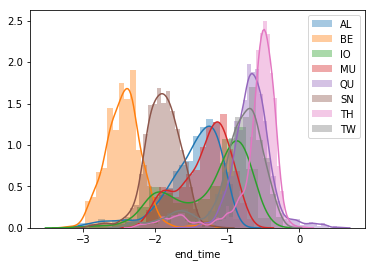

In [192]:
for indv in np.unique(syllable_df.indv):
    sns.distplot(np.log(syllable_df[syllable_df.indv==indv]["end_time"]), label=indv)
plt.legend()

In [193]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:

    syllables_spec = parallel(
        delayed(pad_spectrogram)(spec, pad_length)
        for spec in tqdm(
            syllables_spec, desc="padding spectrograms", leave=False
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0179s.) Setting batch_size=22.
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0688s.) Setting batch_size=126.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1178 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2564 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 4202 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 7285 out of 7285 | elapsed:    1.0s finished


(25.0, 10) (320, 800) 25.0 32 800


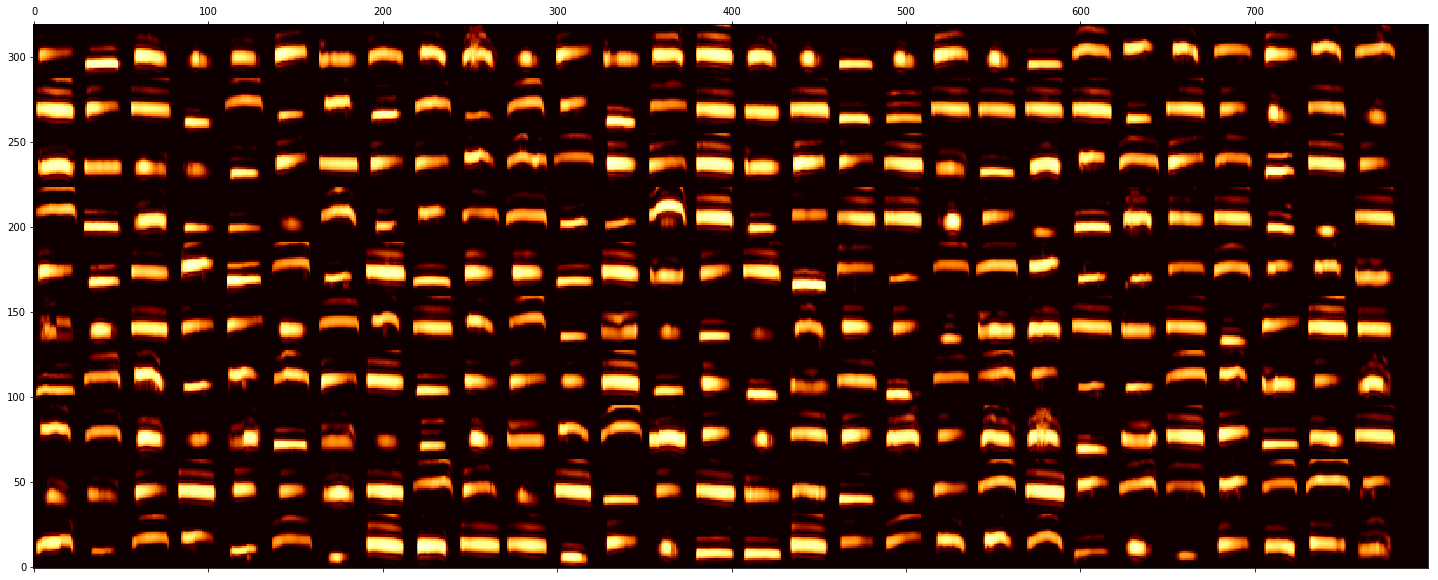

In [194]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

In [195]:
np.shape(syllables_spec)

(7285, 32, 27)

In [196]:
syllable_df['spectrogram'] = syllables_spec

In [197]:
syllable_df[:3]

start_time  end_time indv  indvi    key  \
0         0.0  0.576841   QU      0  QU961   
0         0.0  0.070544   SN      0  SN961   
0         0.0  0.474031   QU      0  QU479   

                                               audio   rate  \
0  [-1.5382879036171296e-05, -0.00013294855745331...  24414   
0  [-6.30847800886783e-07, -6.1899308990145226e-0...  44100   
0  [3.997810370982371e-06, 3.1708158648103554e-05...  24414   

                                         spectrogram  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

### view syllables per indv

In [198]:
syllable_df.indv.unique()

array(['QU', 'SN', 'AL', 'TH', 'MU', 'BE', 'IO', 'TW'], dtype=object)

AL 999
(50.0, 32) (512, 800) 25.0 32 800


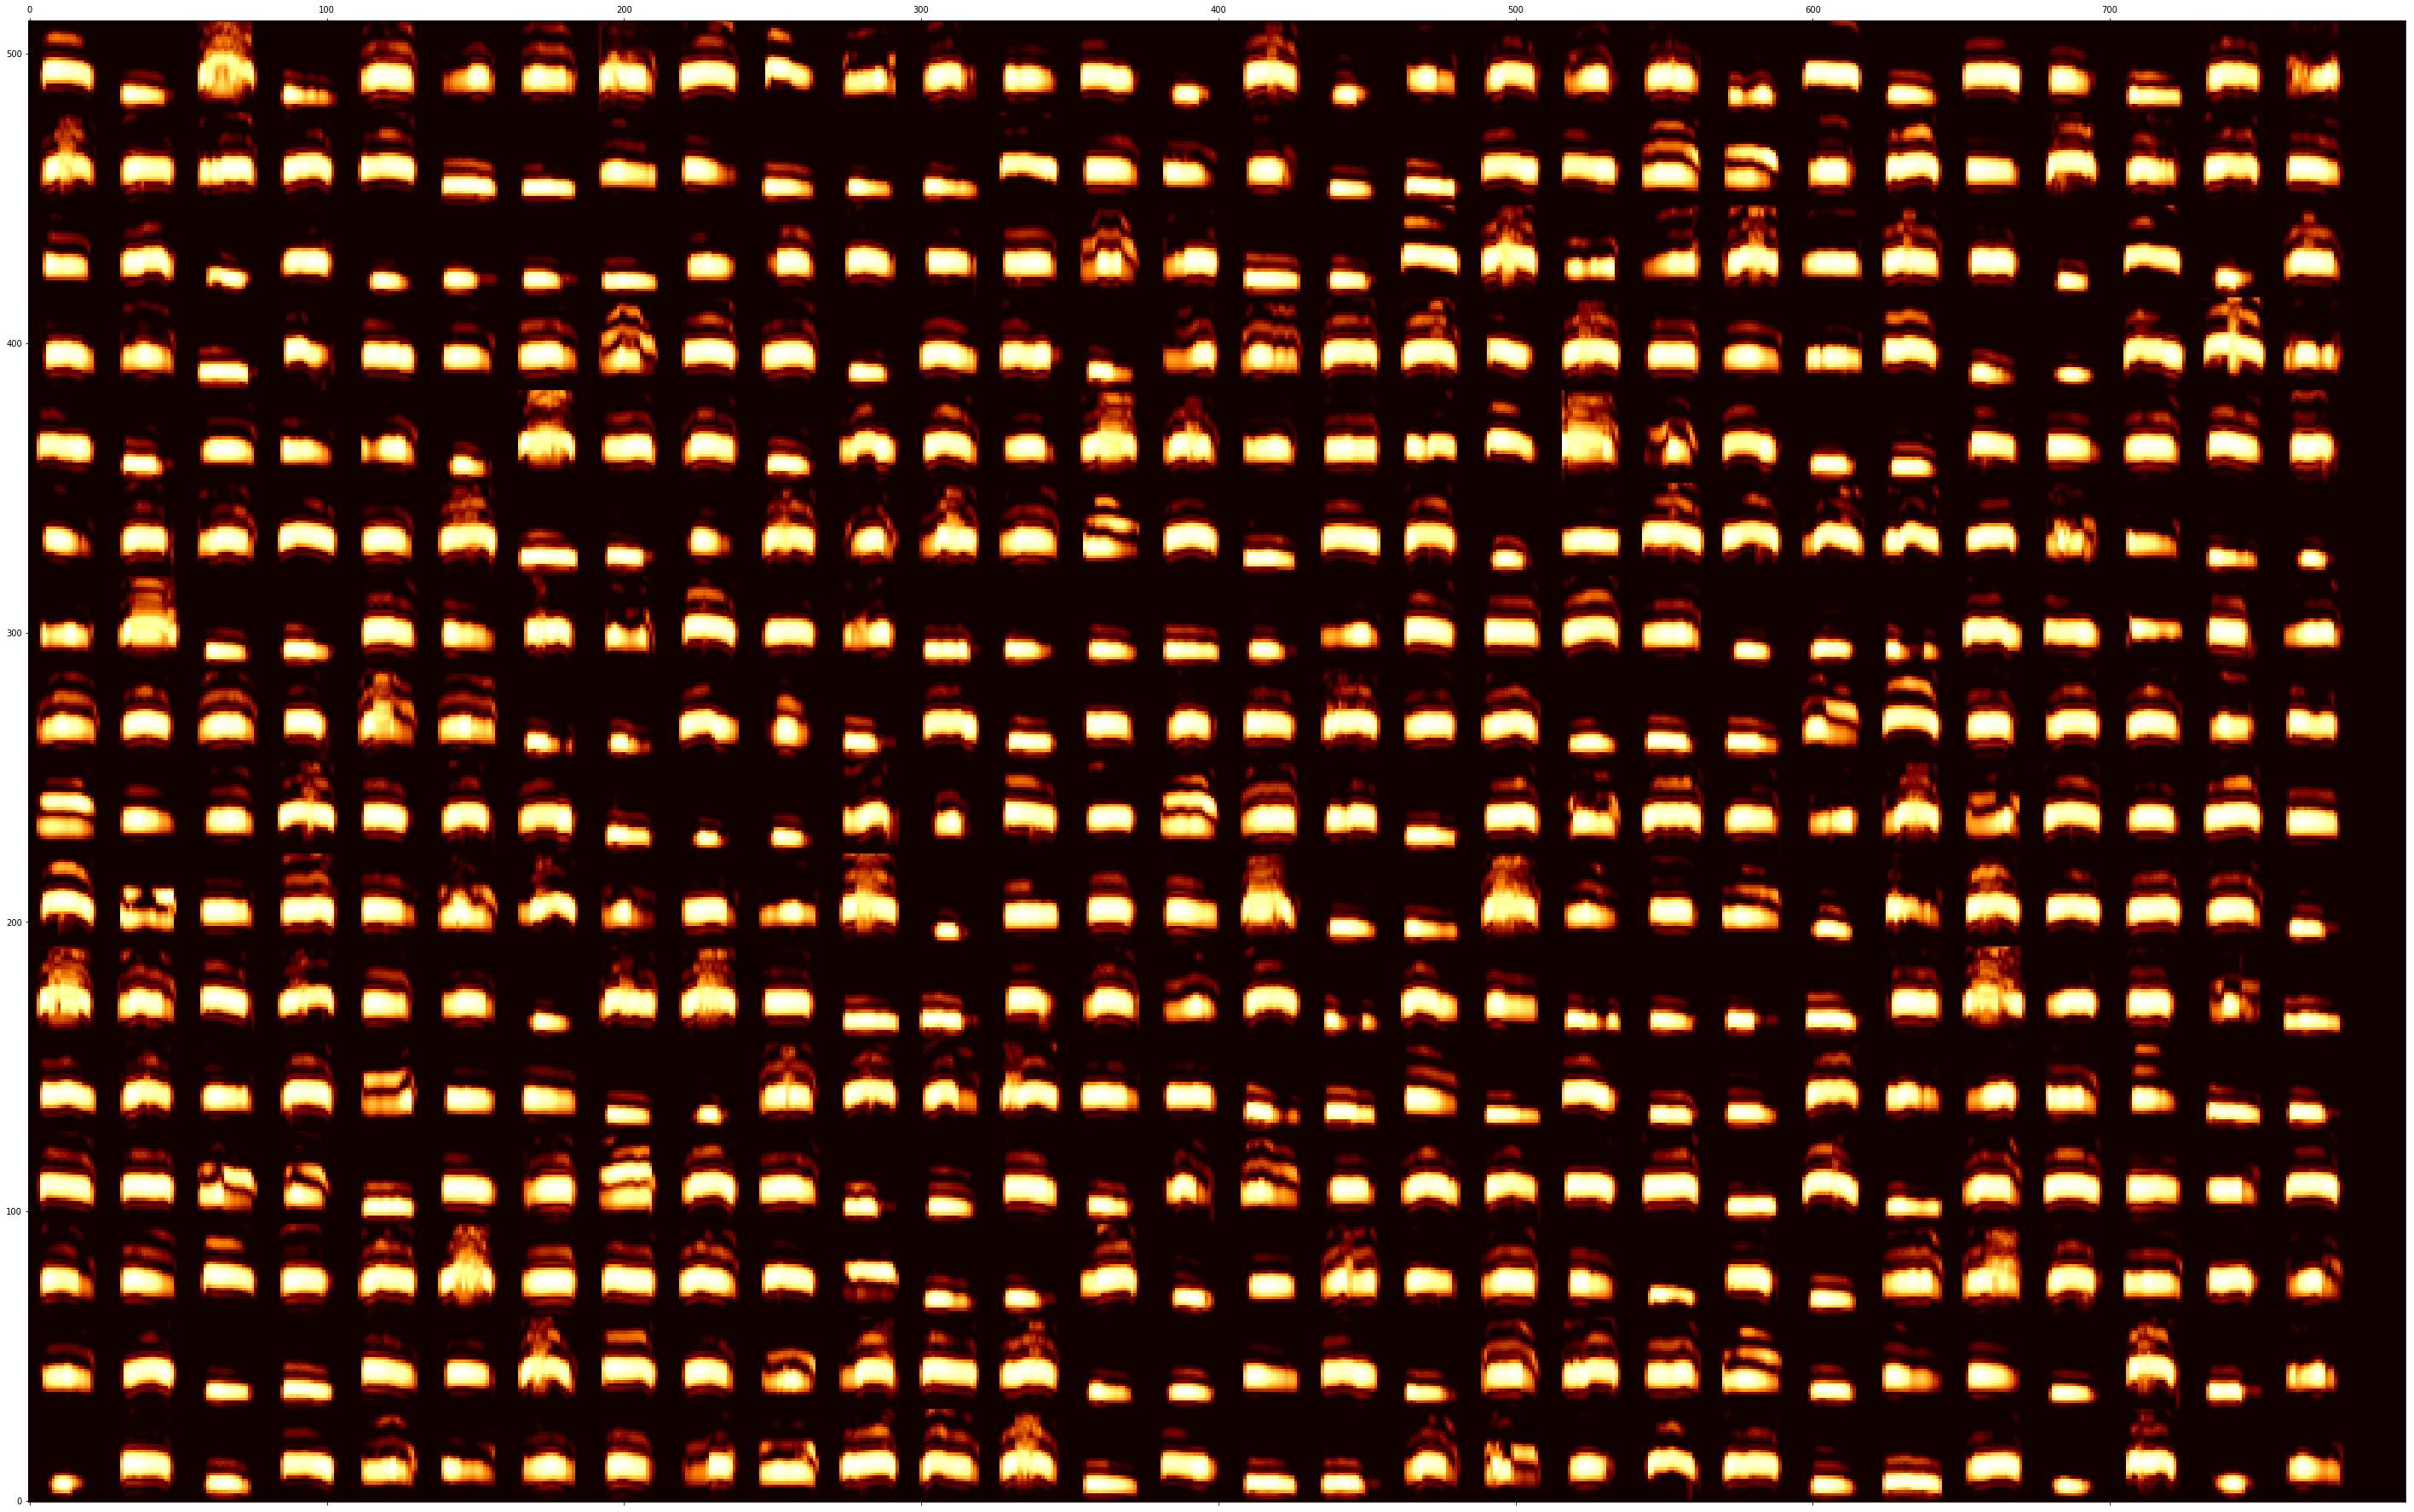

BE 478
(50.0, 32) (512, 800) 25.0 32 800


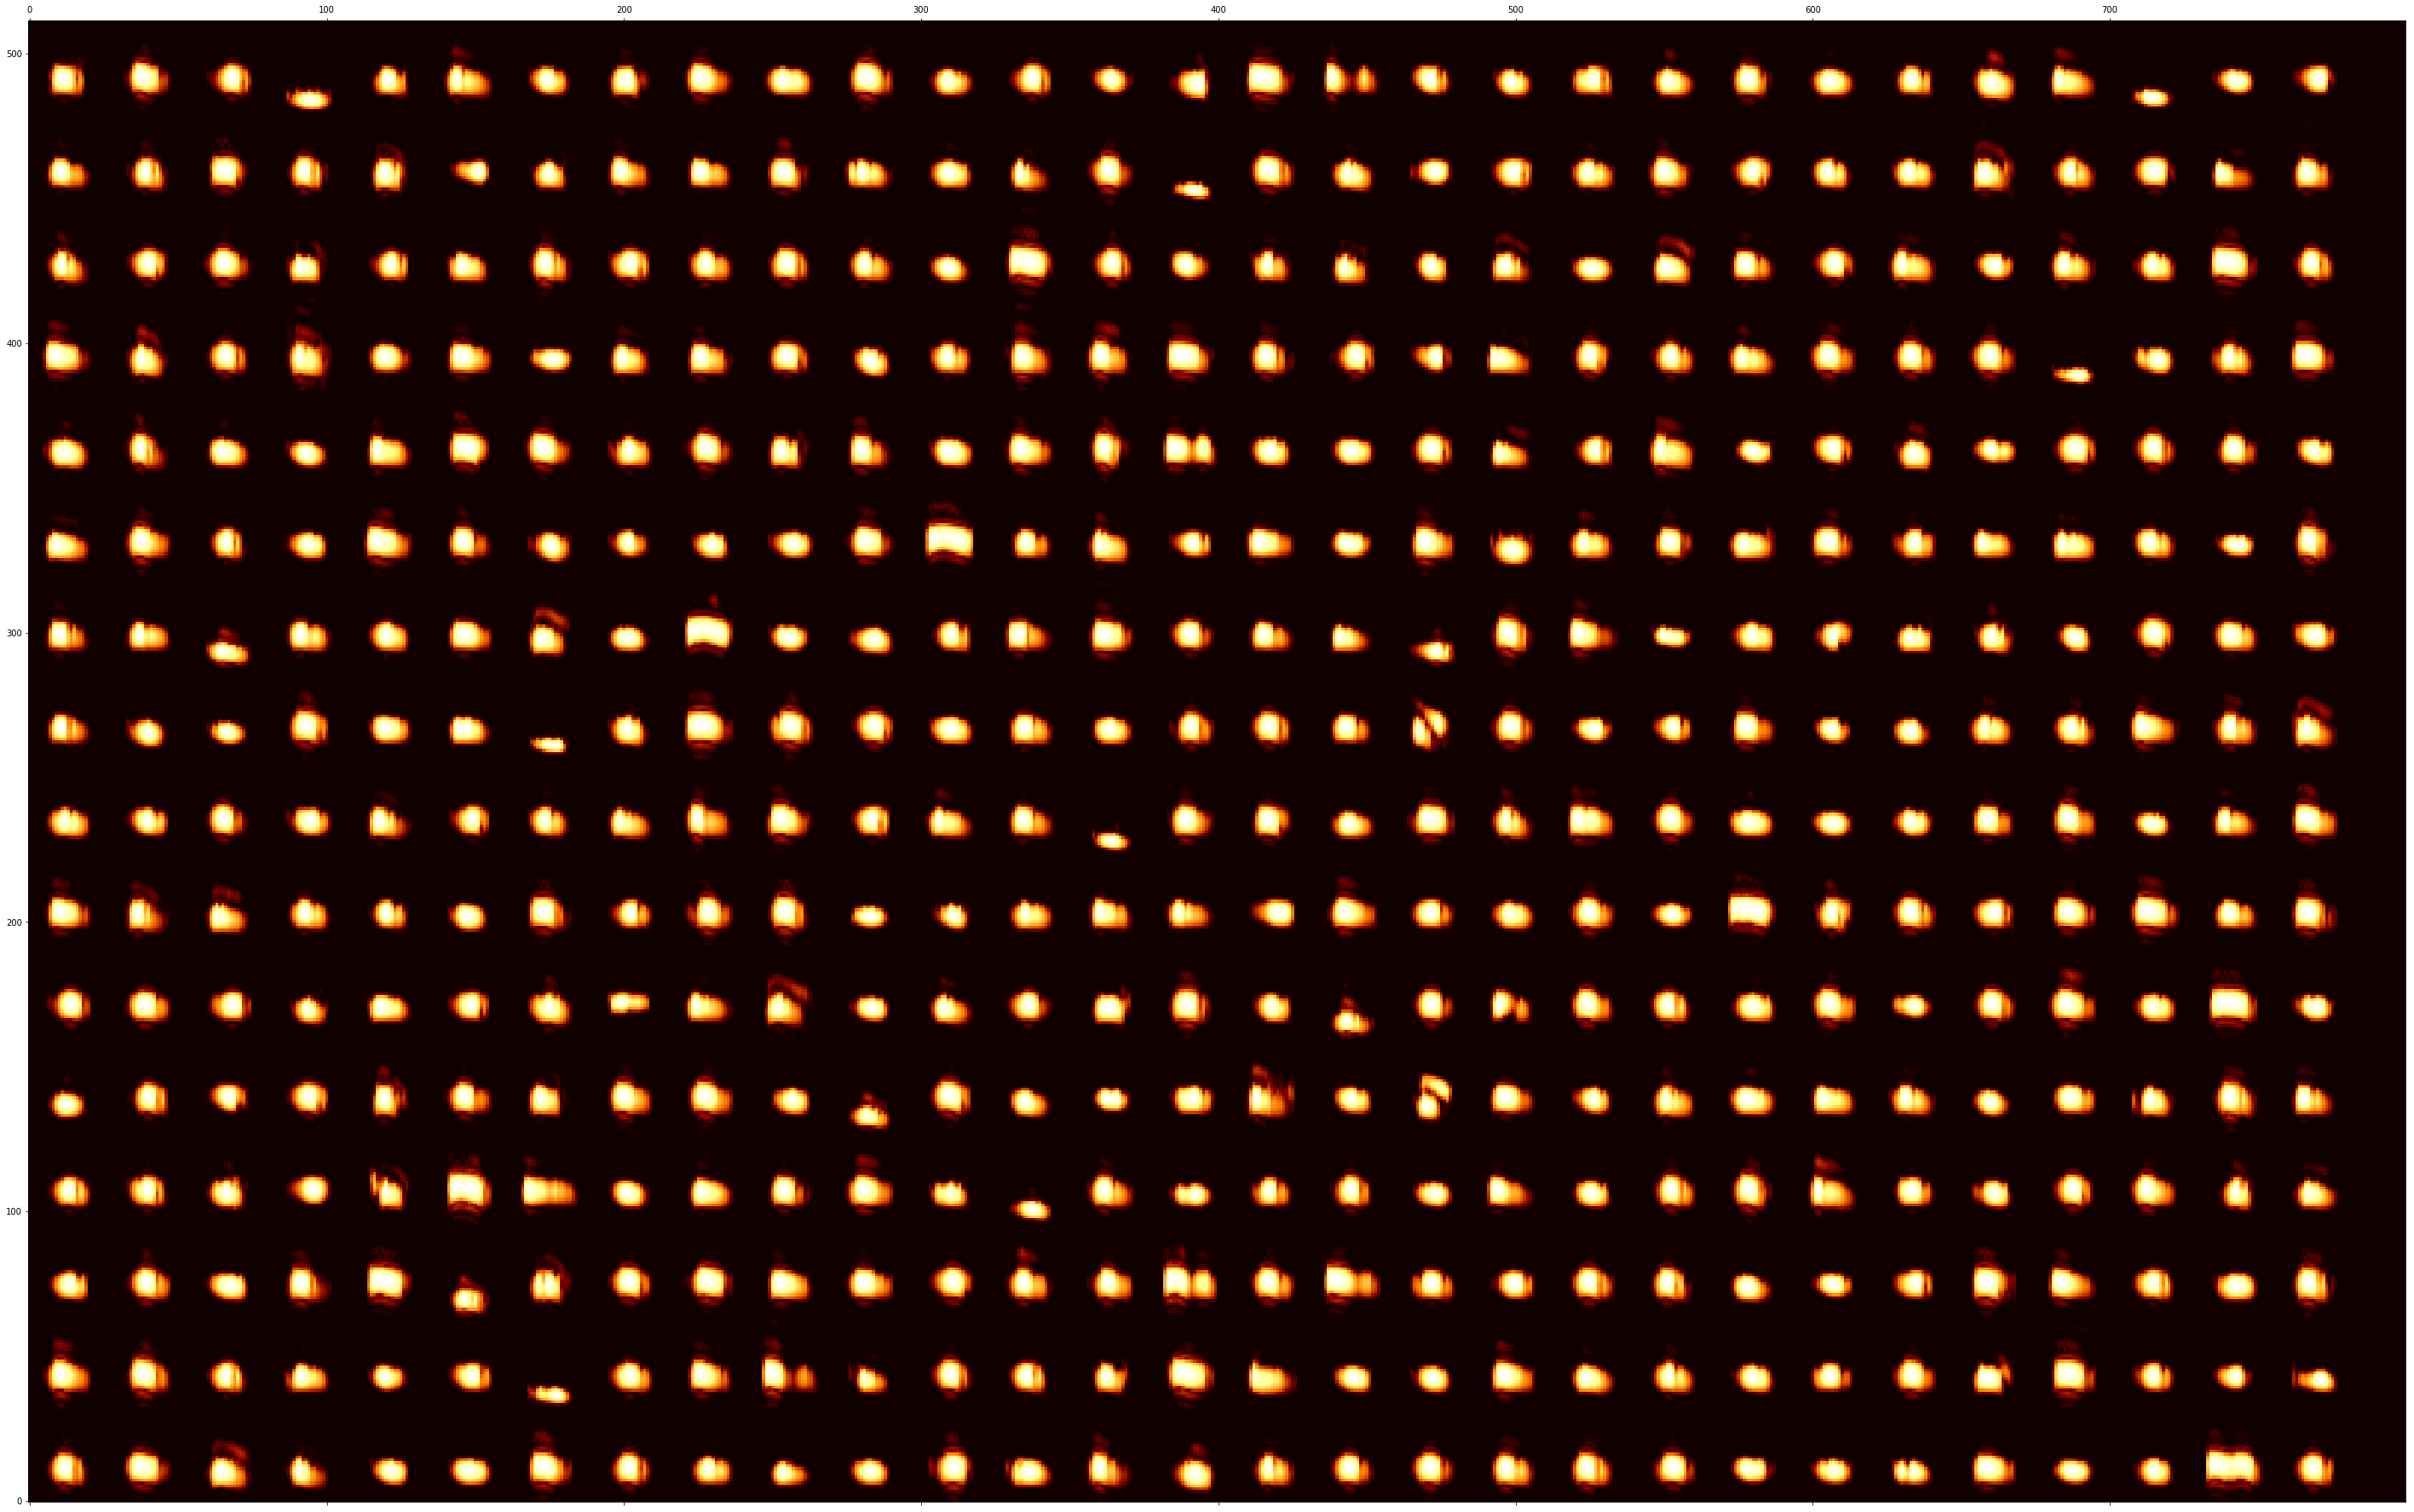

IO 1002
(50.0, 32) (512, 800) 25.0 32 800


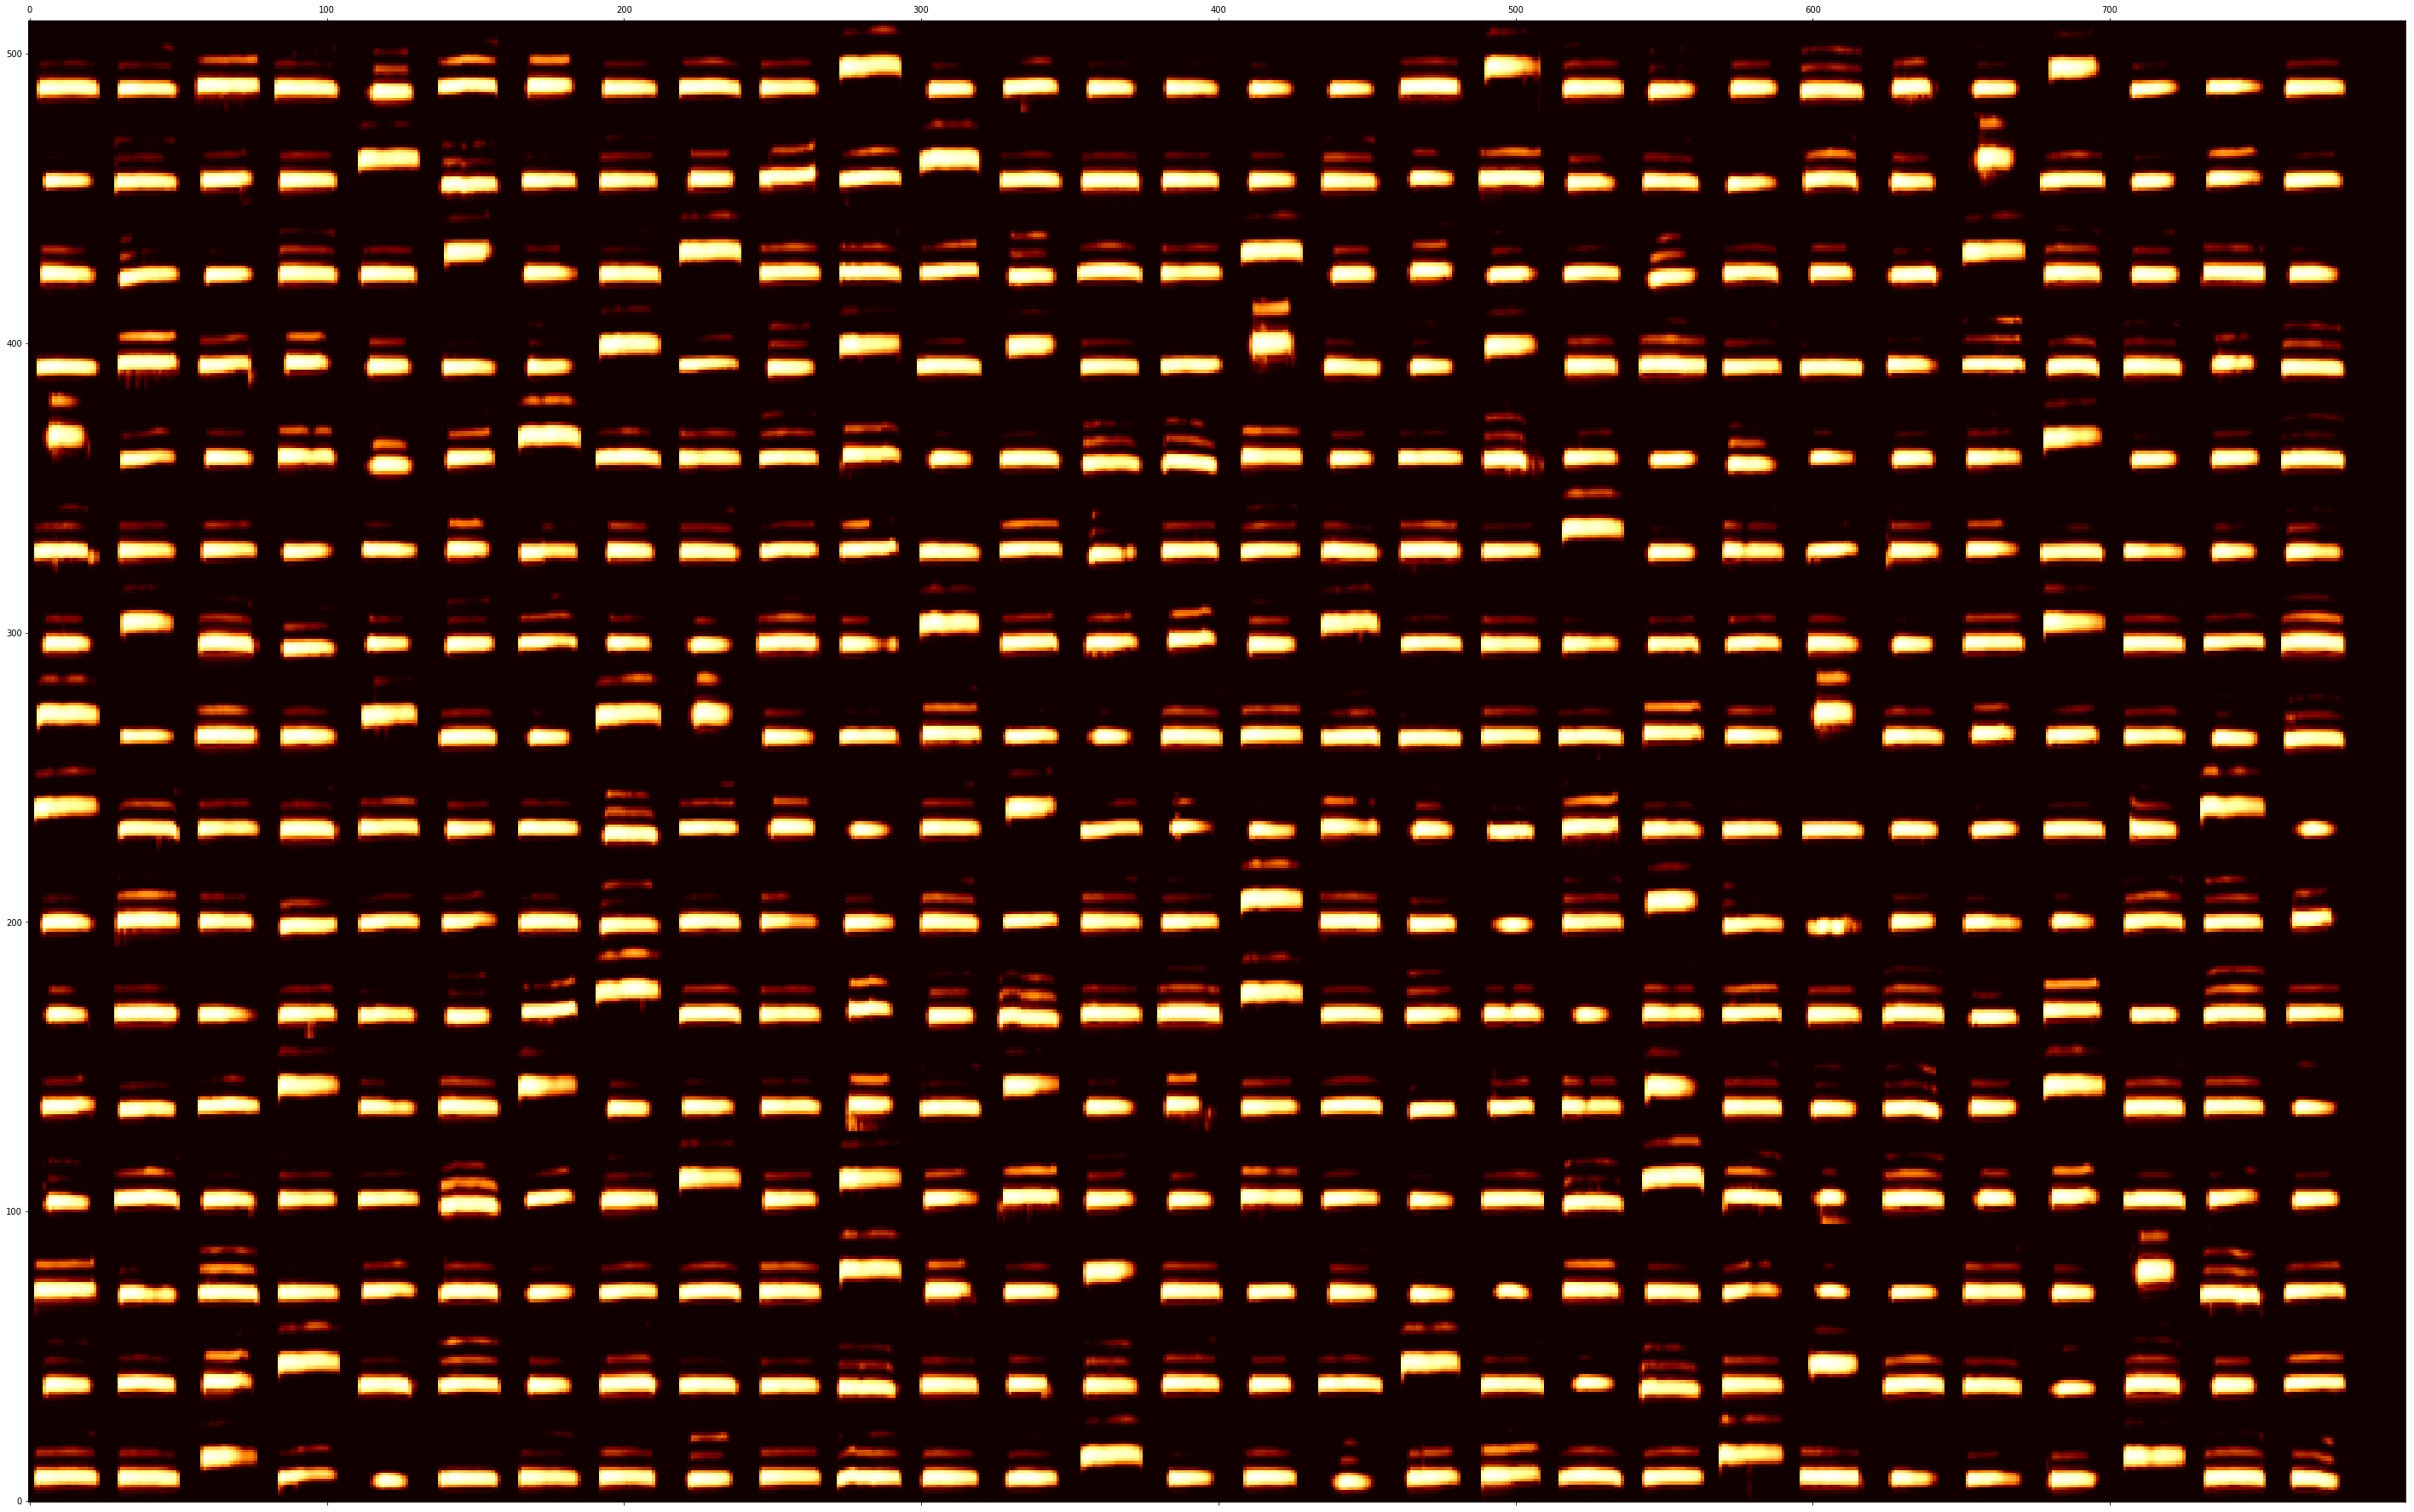

MU 1017
(50.0, 32) (512, 800) 25.0 32 800


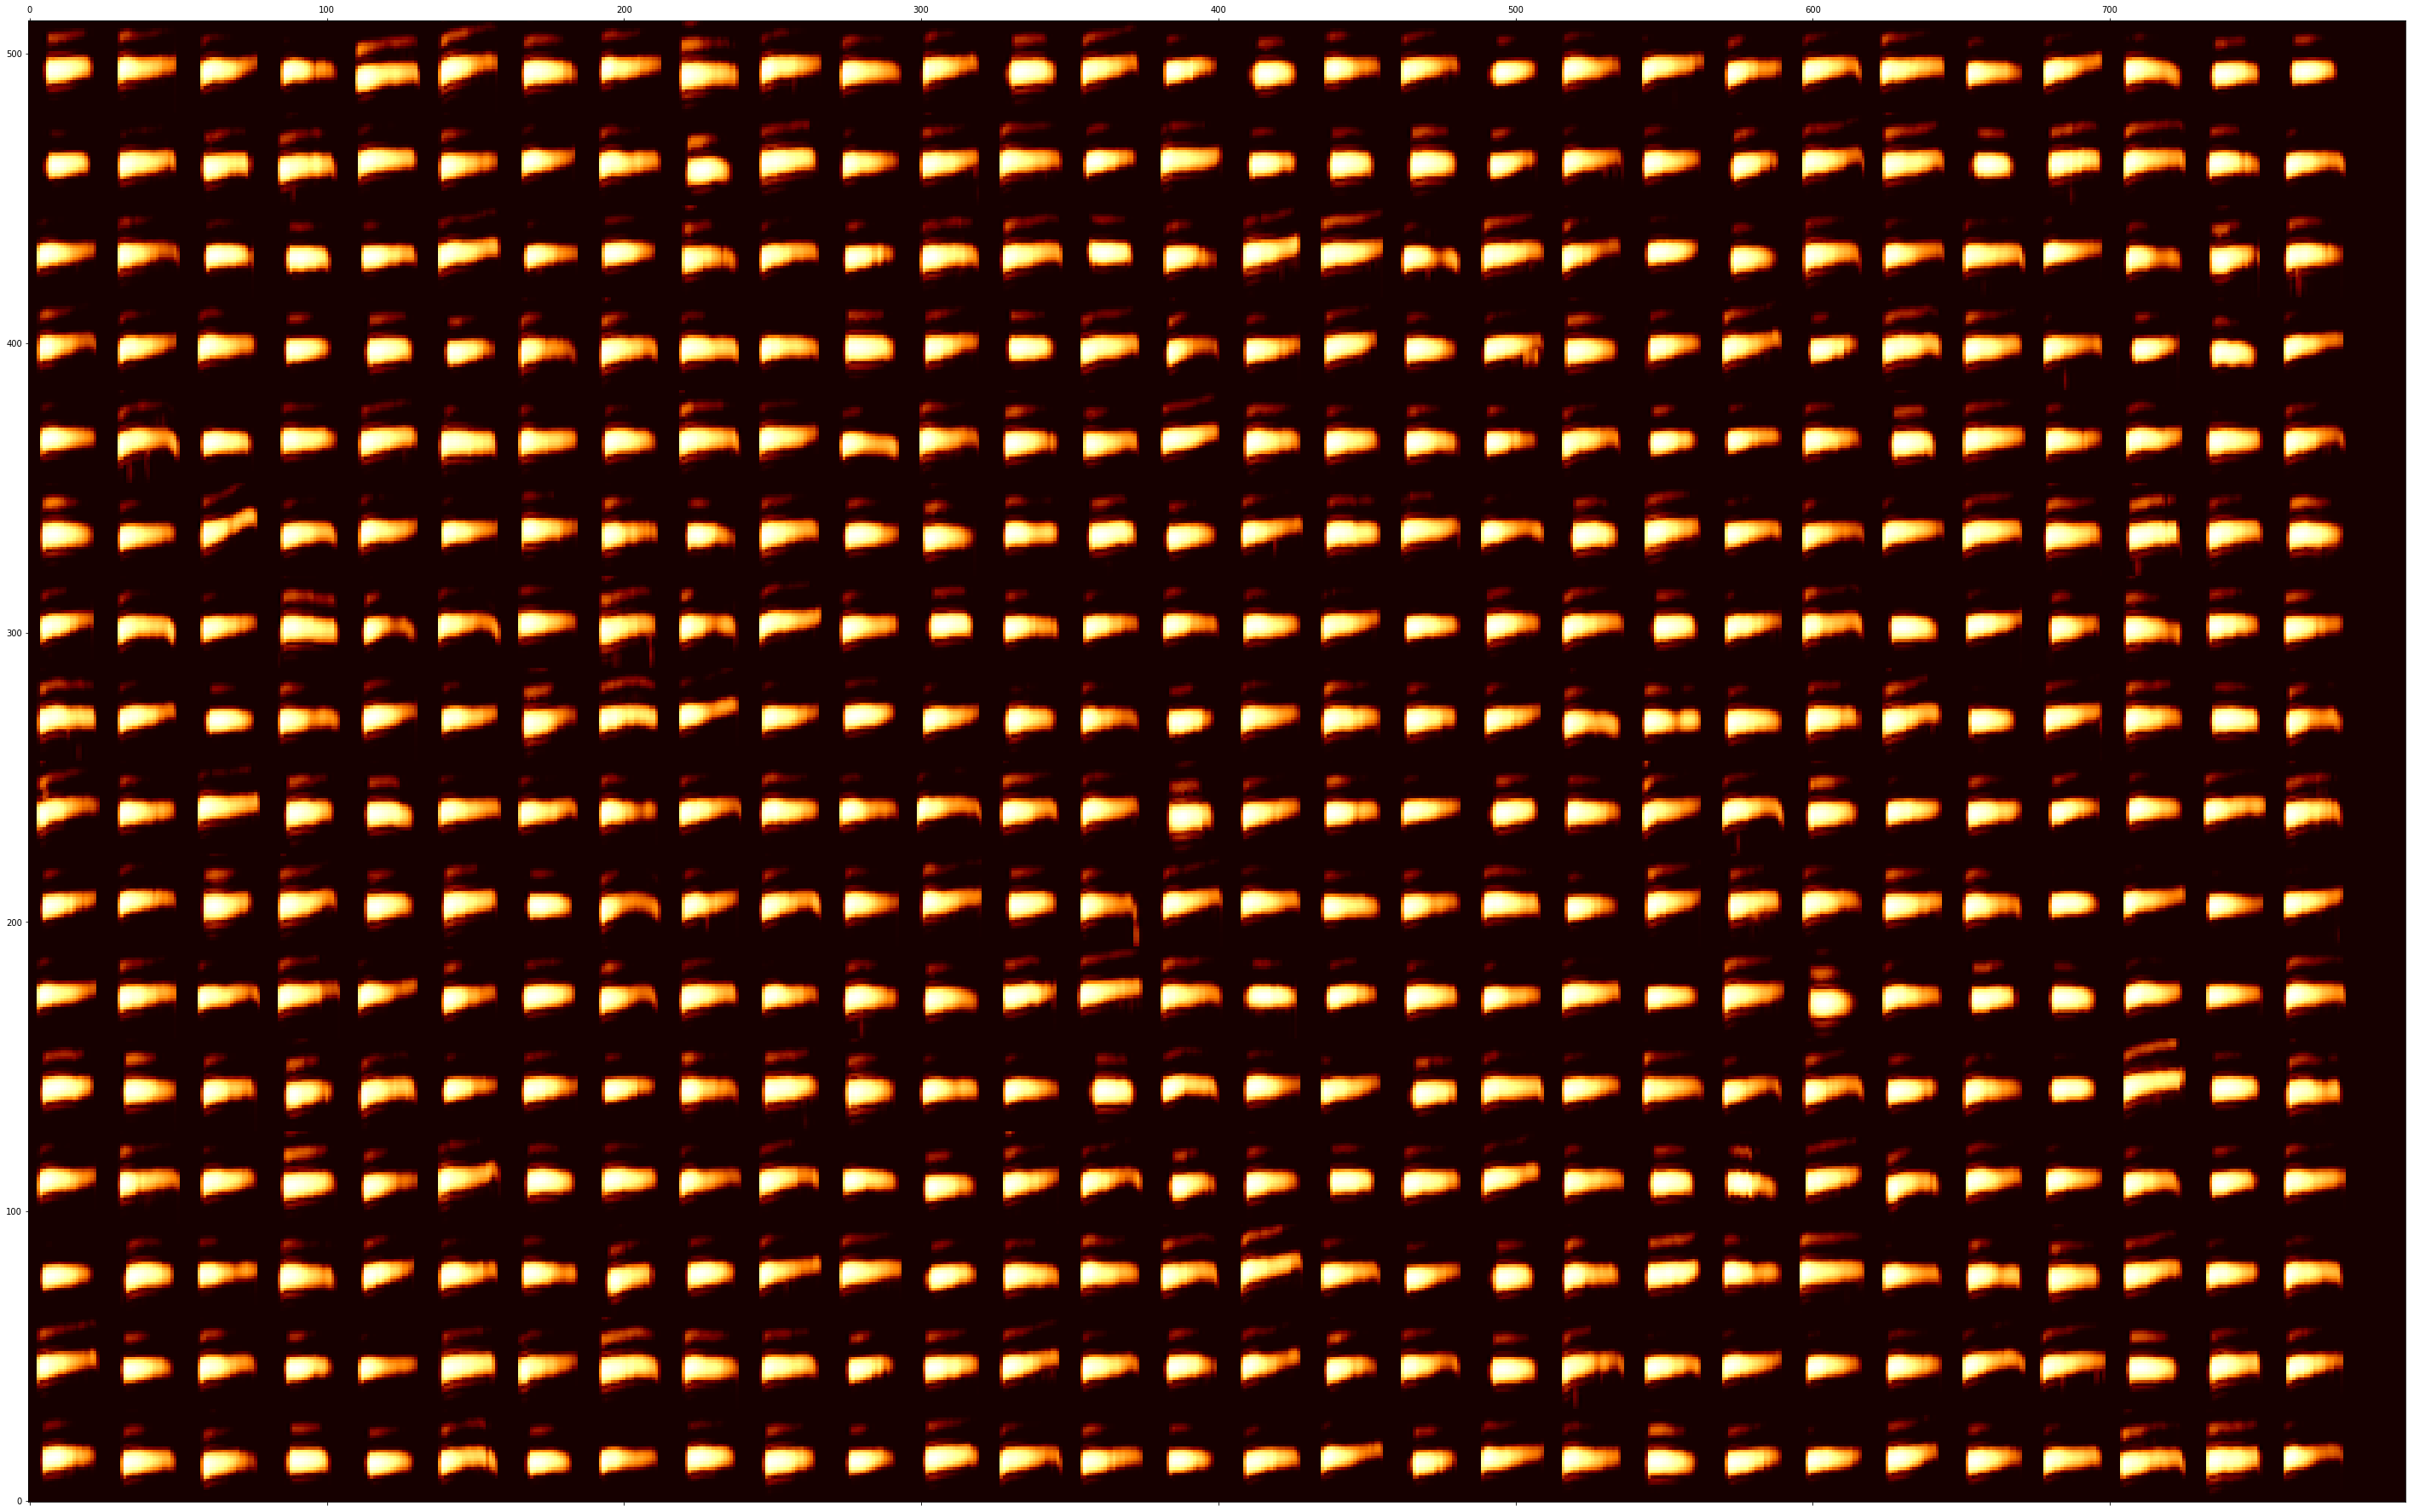

QU 975
(50.0, 32) (512, 800) 25.0 32 800


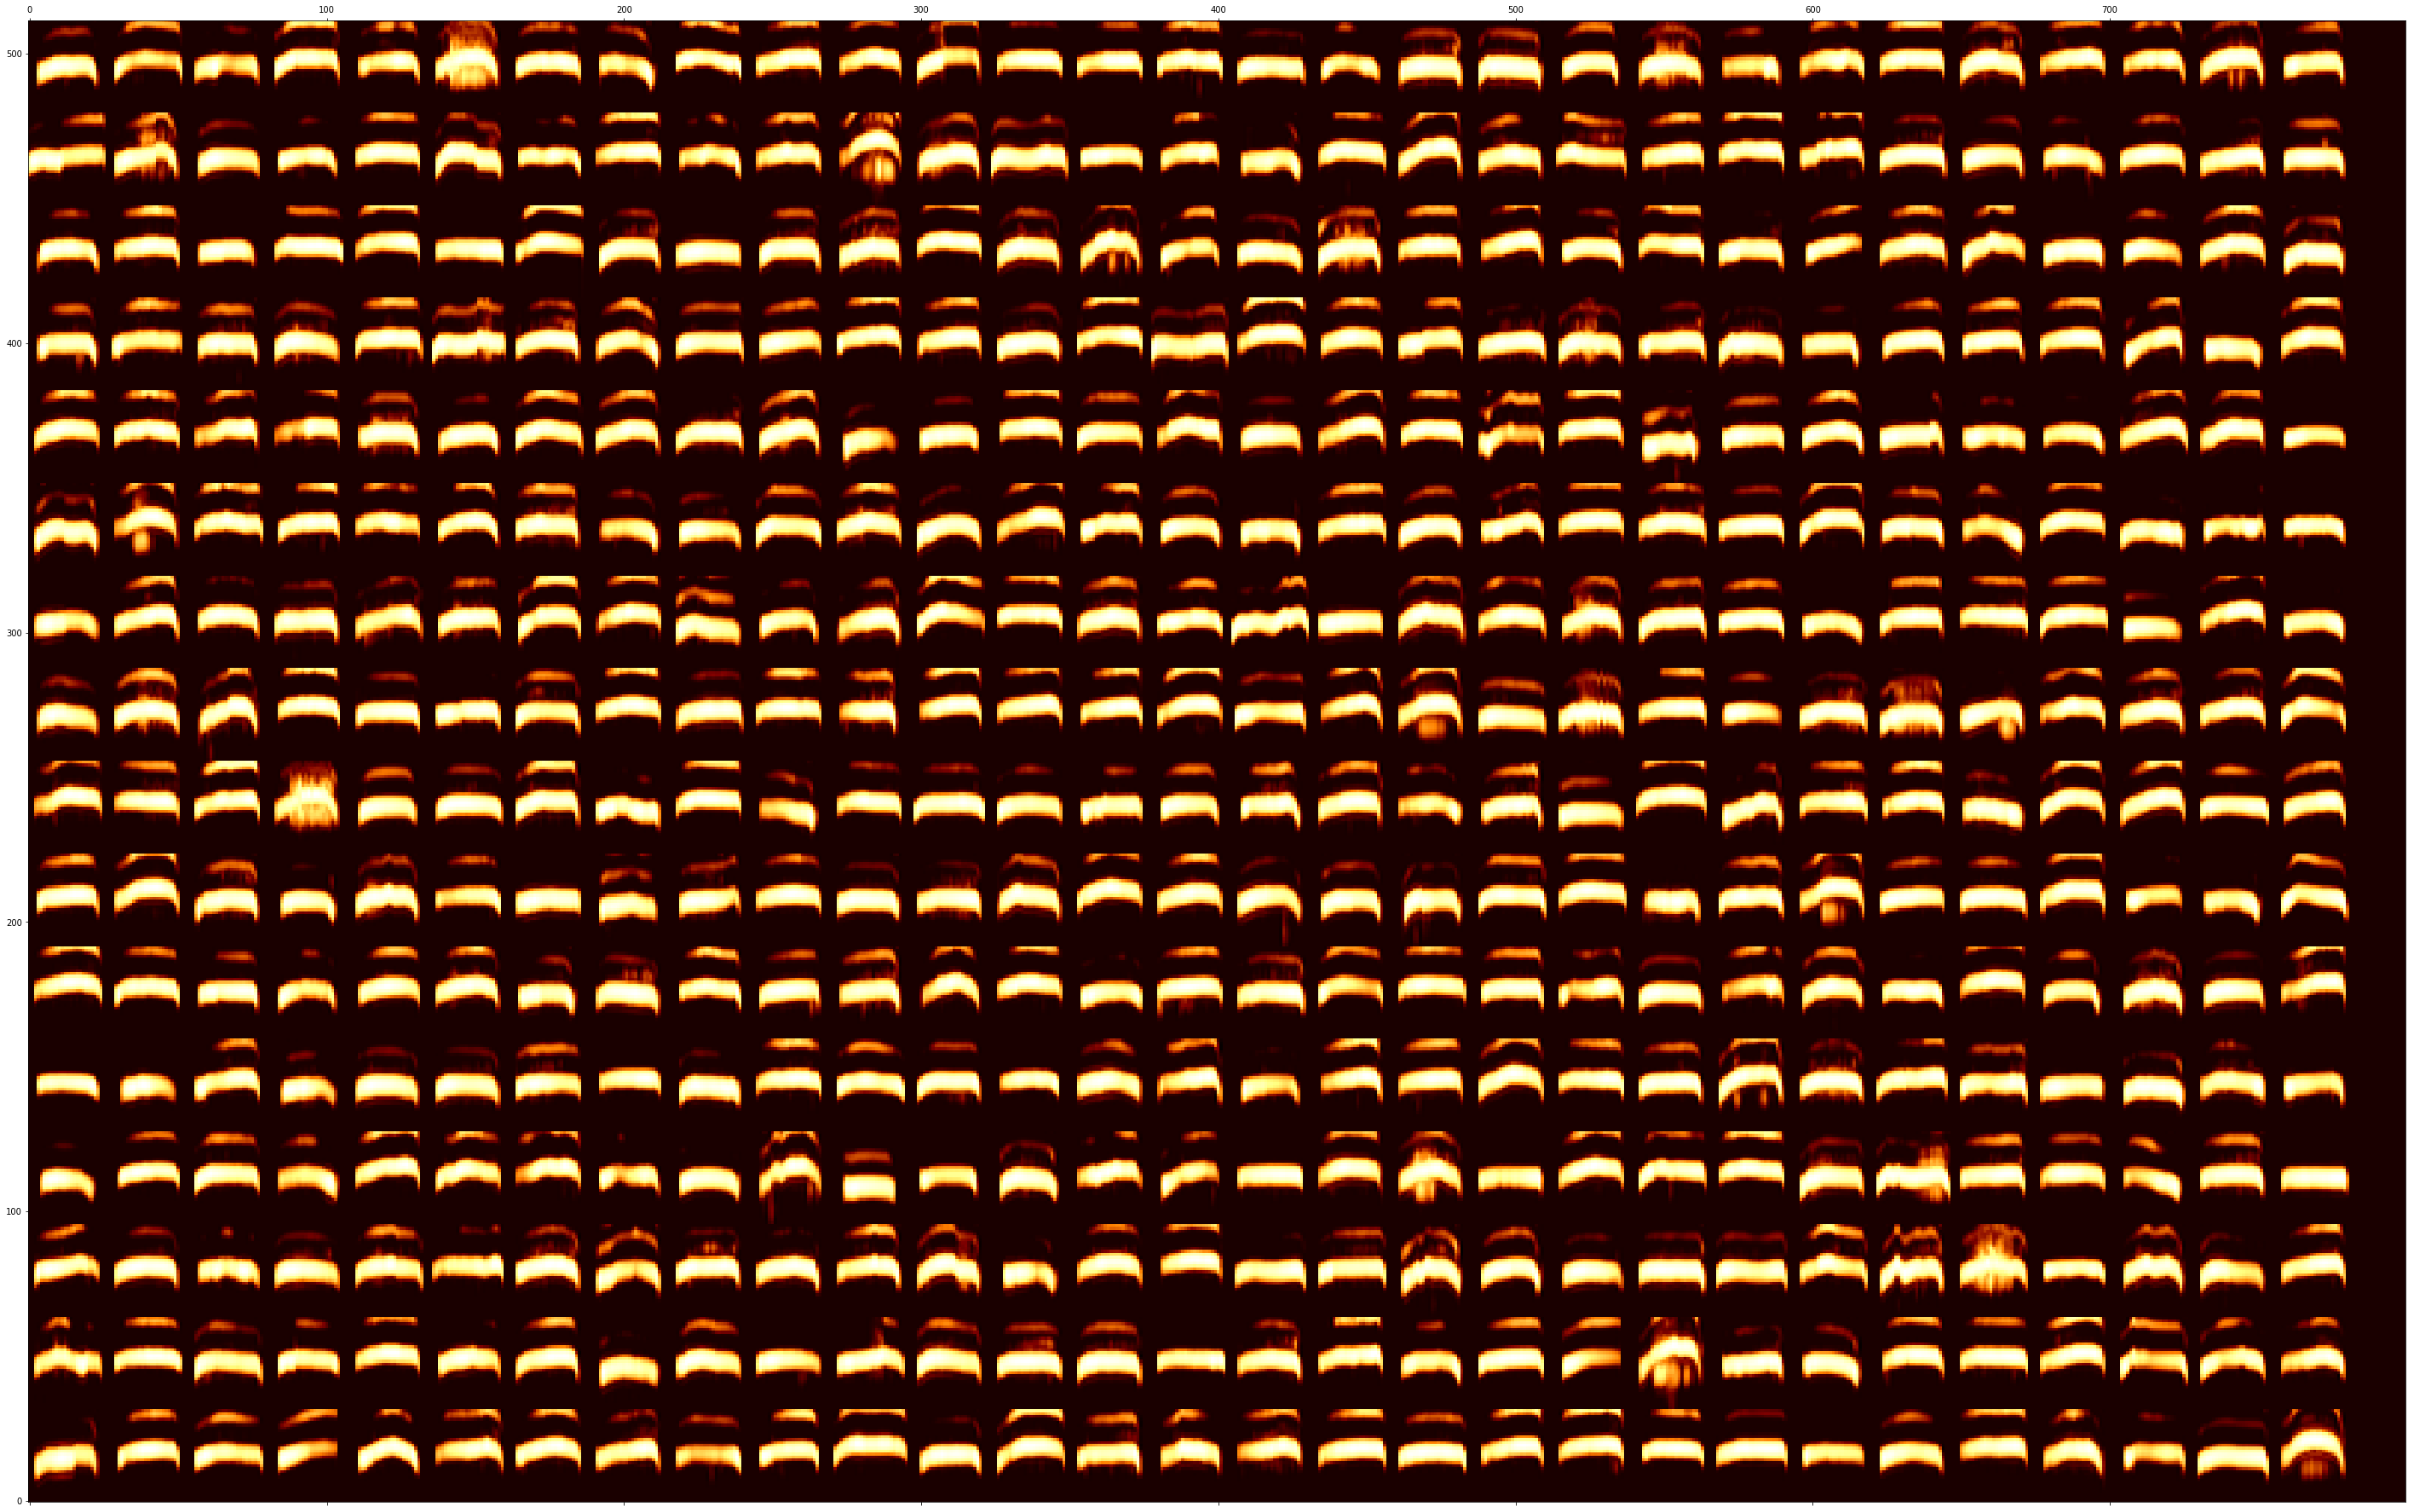

SN 1001
(50.0, 32) (512, 800) 25.0 32 800


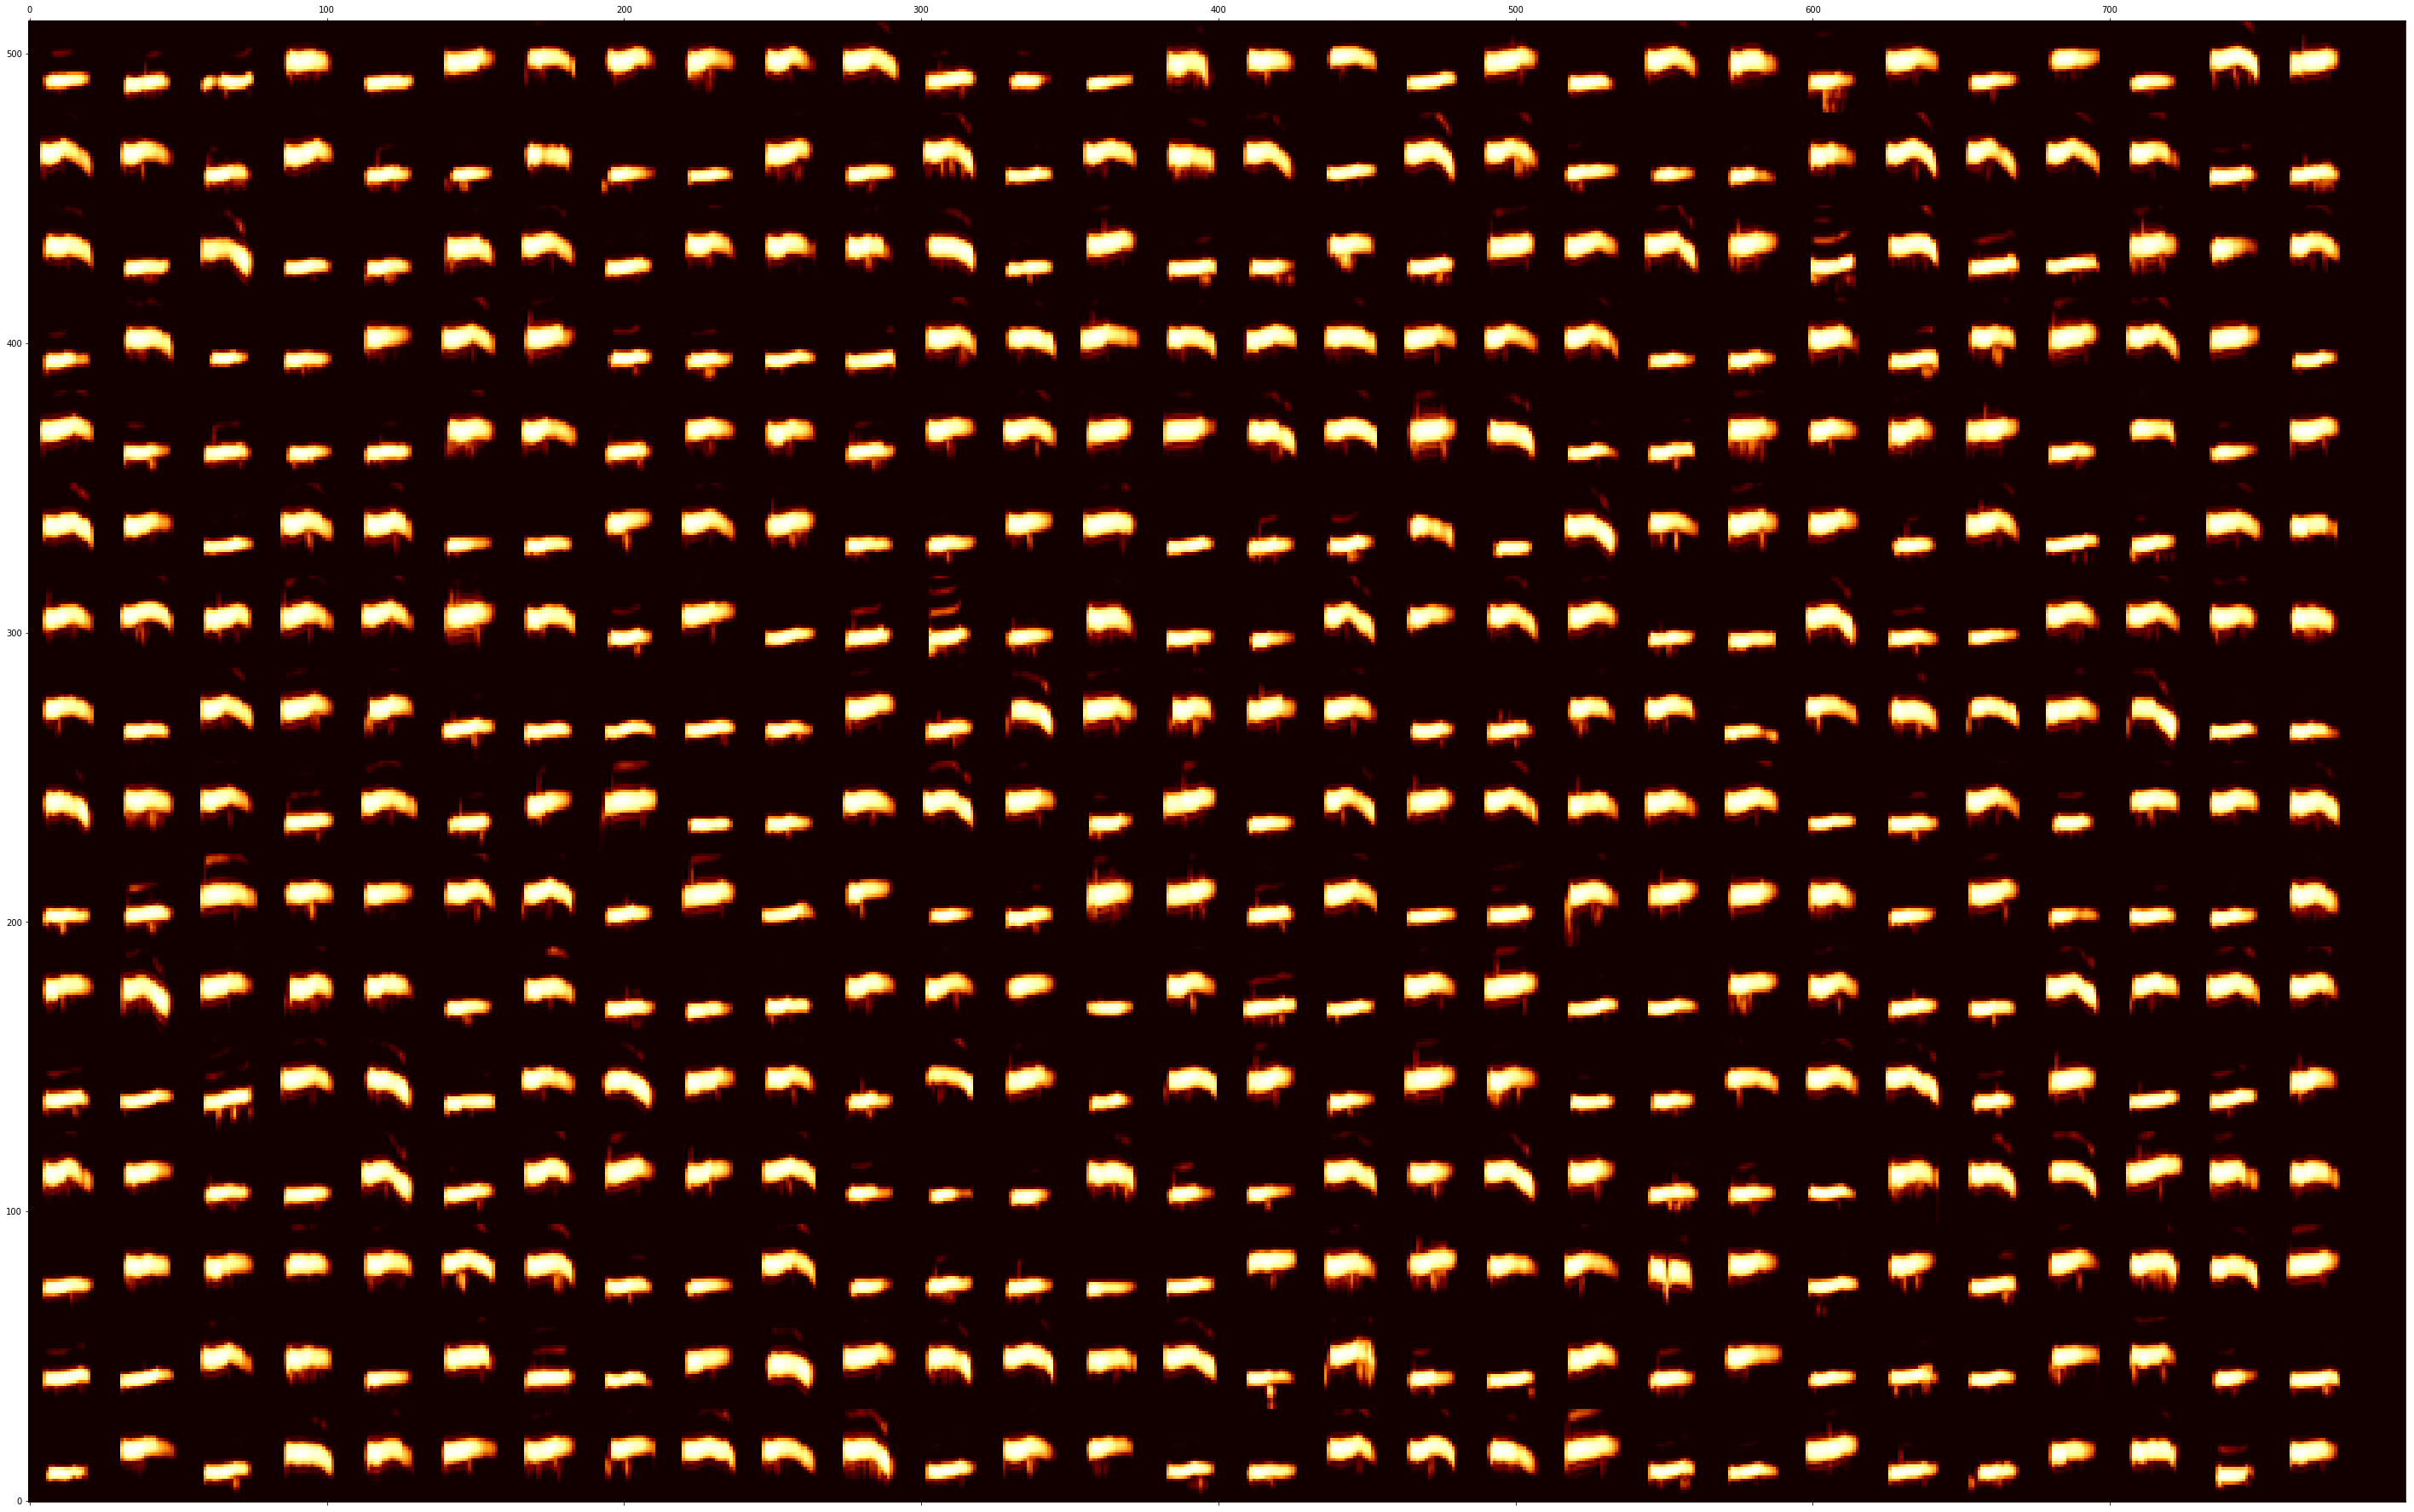

TH 1345
(50.0, 32) (512, 800) 25.0 32 800


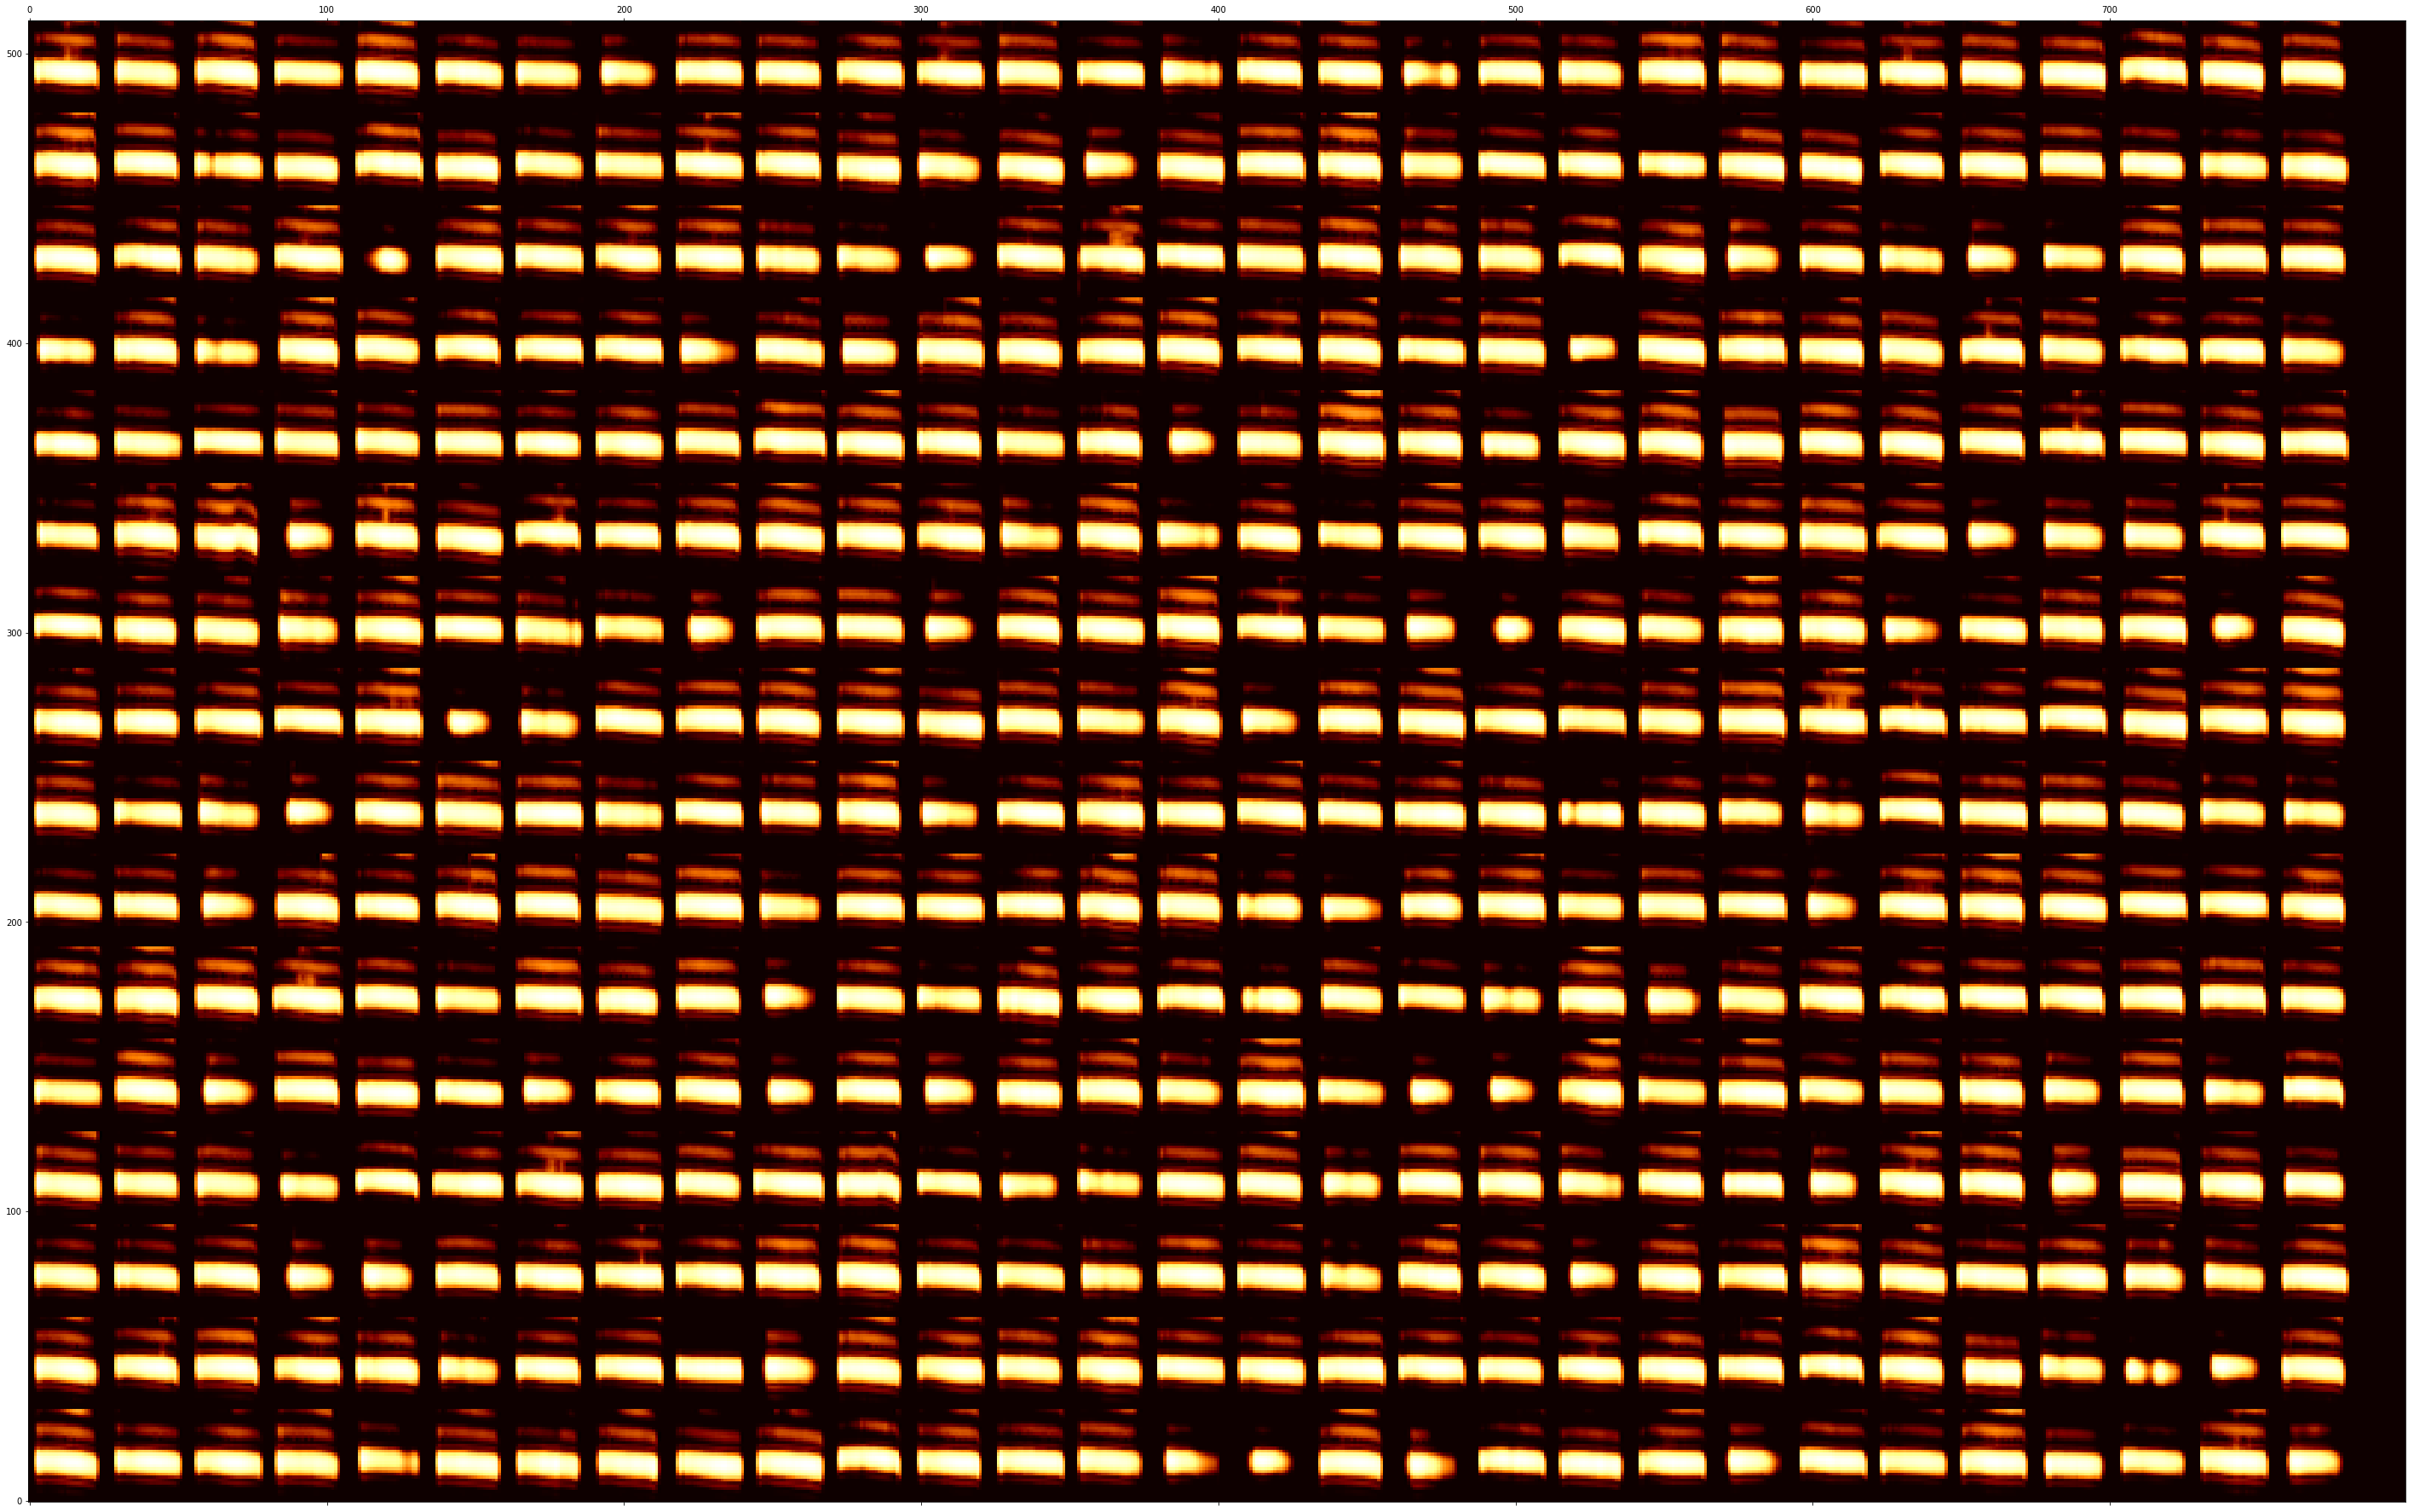

TW 468
(50.0, 32) (512, 800) 25.0 32 800


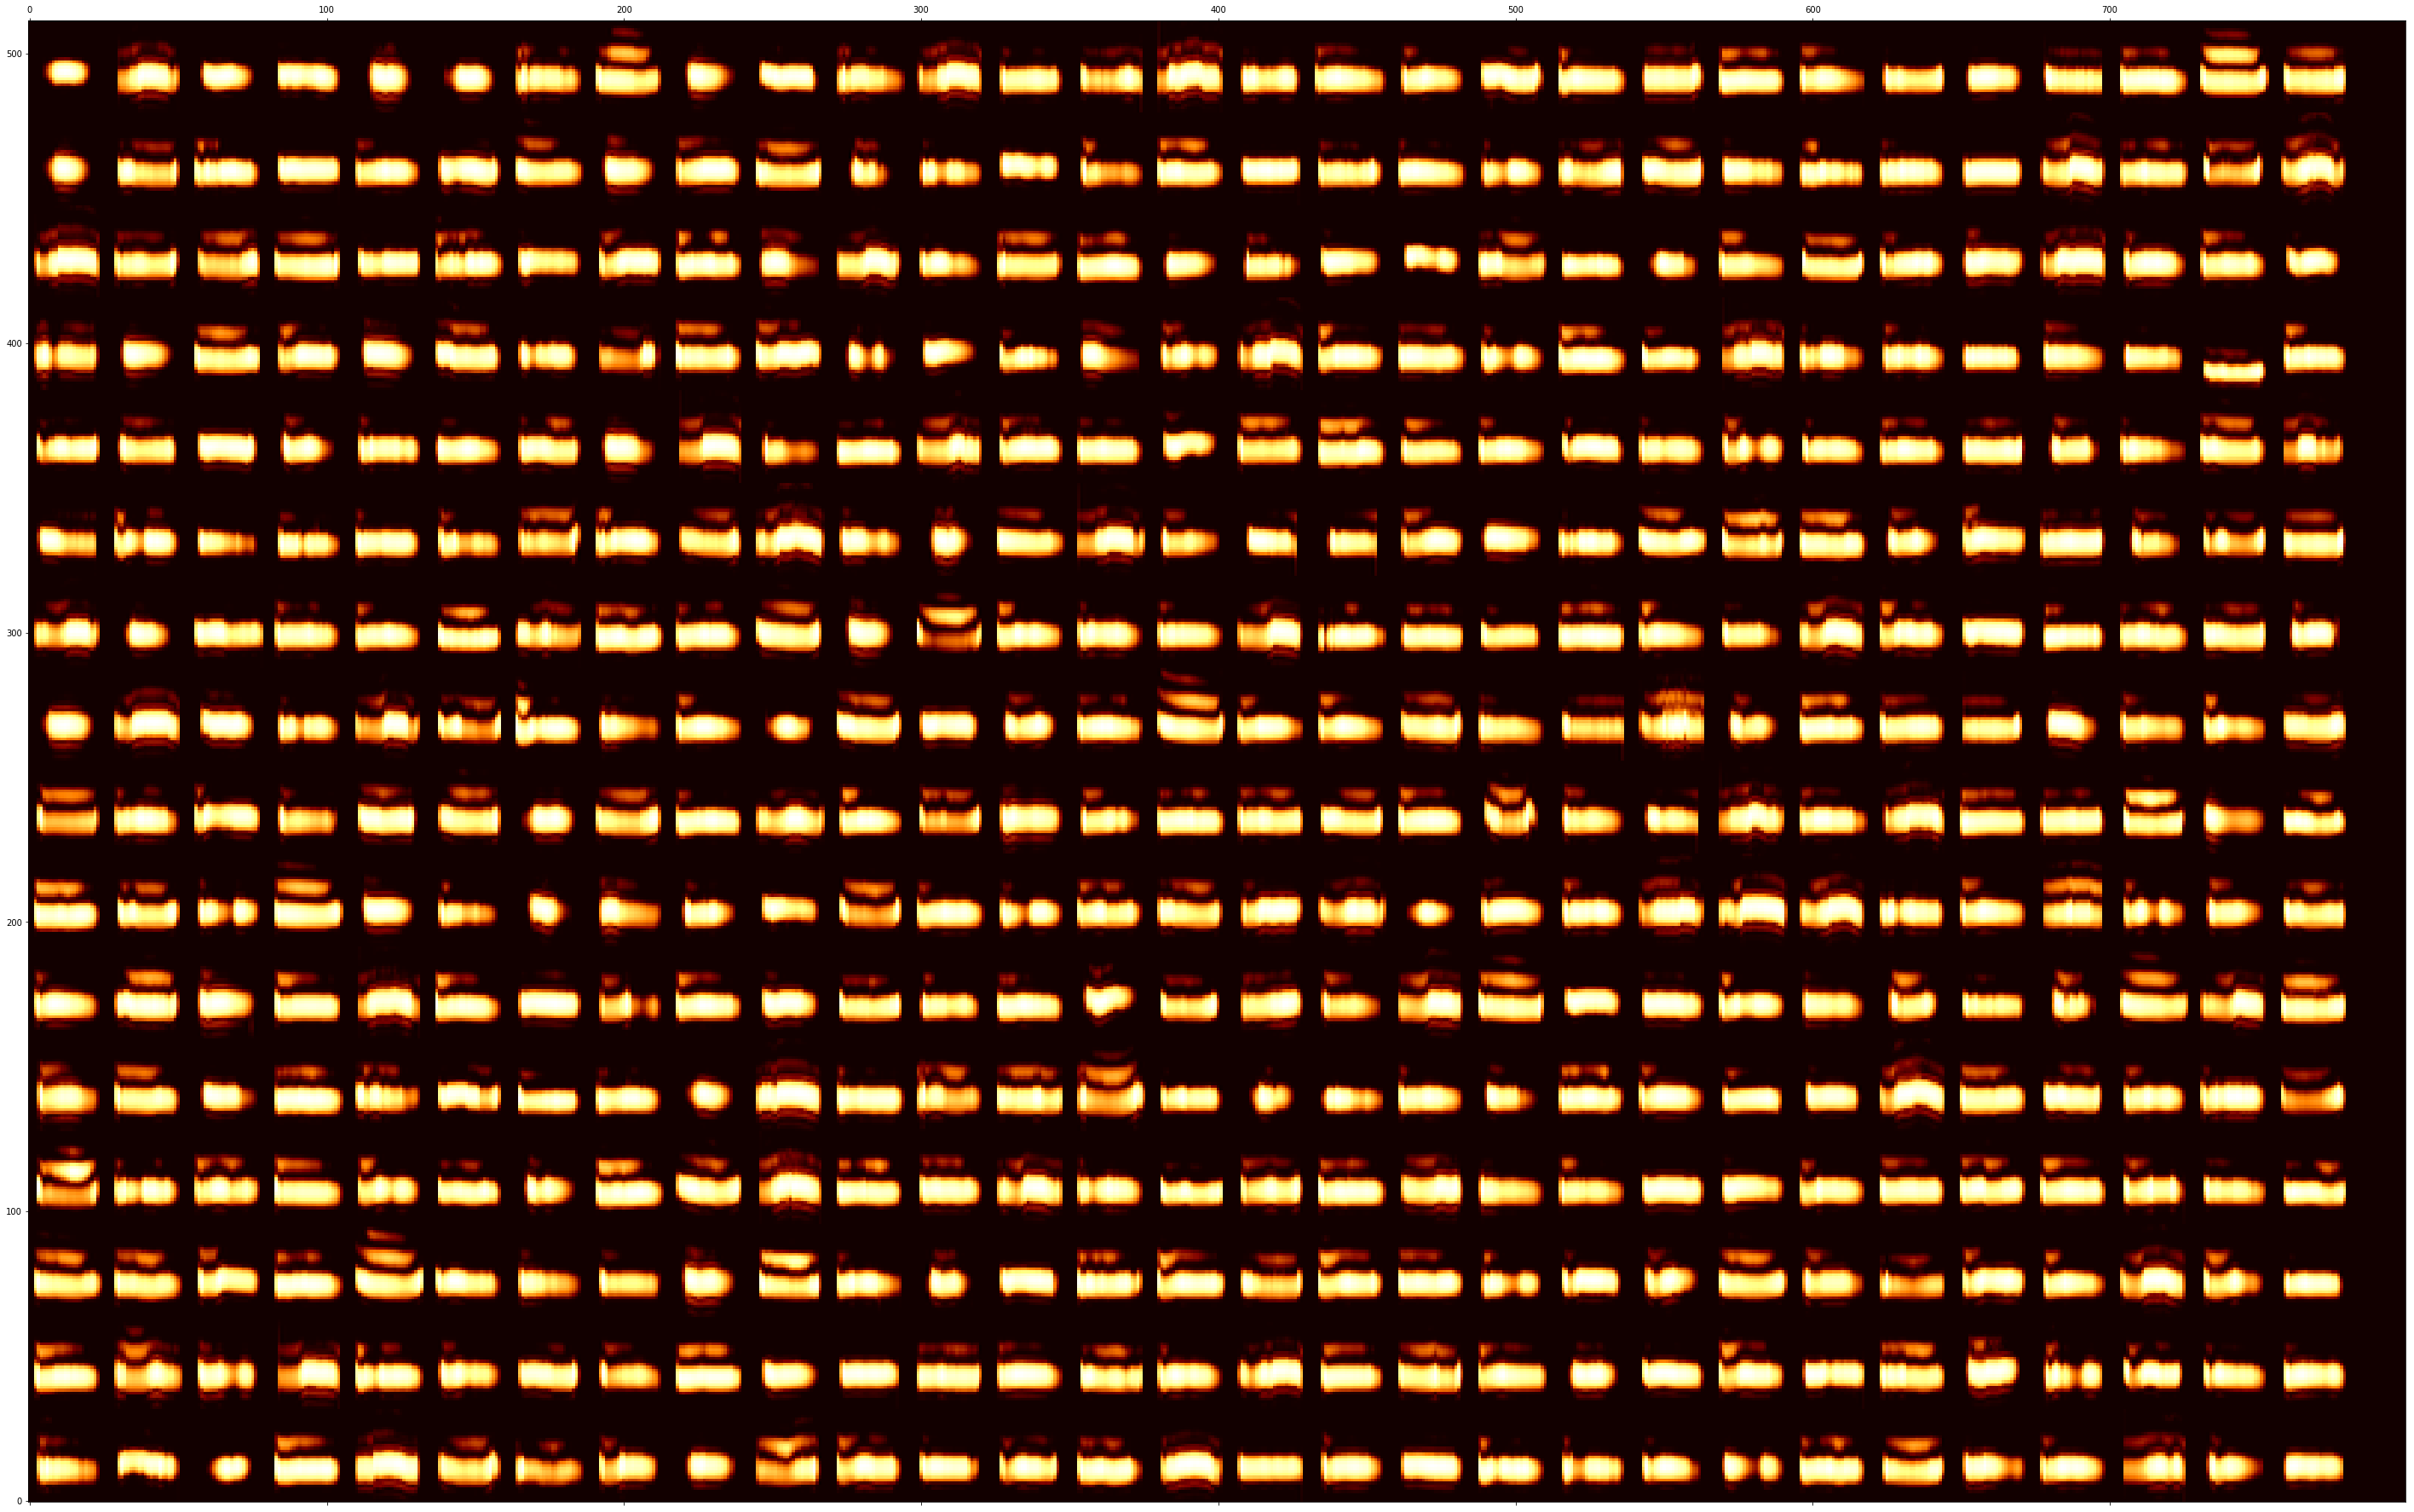

In [199]:
for indv in np.sort(syllable_df.indv.unique()):
    print(indv, np.sum(syllable_df.indv == indv))
    specs = [i/np.max(i) for i in syllable_df[syllable_df.indv == indv].spectrogram.values]
    draw_spec_set(specs, zoom=2,
                  maxrows=16, 
                  colsize=25)

### save dataset

In [200]:
save_loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / 'macaque.pickle'
ensure_dir(save_loc)
syllable_df.to_pickle(save_loc)